In [ ]:
# First, upload the dataset by following these commands:
# Go to https://drive.google.com
# Navigate to My Drive
# Click "New" → "File Upload"
# Upload deam_project_data.zip, which is downloaded from https://github.com/Talaxika/Picture-to-music

In [ ]:
!pip install kagglehub --quiet

In [ ]:
!pip install librosa soundfile --quiet

In [60]:
import os
import pandas as pd
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from collections import Counter
from random import sample

In [ ]:
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("📎 Please upload your kaggle.json API key file")
    from google.colab import files
    uploaded = files.upload()  # Upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
dataset_path = kagglehub.dataset_download("magdawjcicka/emotic")
img_dir = f"{dataset_path}/img_arrs"
print("EMOTIC image data path:", img_dir)

✅ EMOTIC image data path: /kaggle/input/emotic/img_arrs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# If help needed:
# !ls "/content/drive/MyDrive"

 20220410_210853.pdf
 277215555_1421669364918349_5725126775532216862_n.jpg
 277316159_318237320375303_2639721636218327997_n.jpg
 277375538_526110968858485_2422943486046531735_n.jpg
 901219011_Sladun.ino
'Colab Notebooks'
 homework_01
 Motivational_letter.docx
 Motivational_letter_SA.pdf
 project_data.zip
 Диплома.pdf
 СладунА_Диплома.pdf


In [ ]:
!unzip -q "/content/drive/MyDrive/project_data.zip" -d "/content/project_data"

In [ ]:
audio_dir = "/content/project_data/music"

In [ ]:
# If help needed:
# !ls /content/project_data

project_data


In [ ]:
df_train = pd.read_csv("/content/project_data/cleaned_train_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])
df_val = pd.read_csv("/content/project_data/cleaned_val_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])
df_test = pd.read_csv("/content/project_data/cleaned_test_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 41321, Val: 3271, Test: 10003


In [63]:
class ImageAudioDataset(Dataset):
    def __init__(self, df, img_dir, audio_dir, sr=44100, max_sec=50):
        """
        sr : int, optional
            Target sampling rate for audio files. All audio will be resampled to this rate. Default is 44100 Hz.
        max_sec : int, optional
            Maximum duration of audio in seconds. Audio will be truncated or zero-padded to exactly `sr * max_sec` samples. Default is 50 seconds.
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.audio_dir = audio_dir
        self.sr = sr
        self.max_len = sr * max_sec  # 50 seconds = 2,205,000 samples
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.img_dir, row["image_file"])
        img = np.load(img_path).astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        # Load audio
        audio_id = row["audio_id"].split("-")[0]
        audio_path = os.path.join(self.audio_dir, f"{audio_id}.mp3")
        y, _ = librosa.load(audio_path, sr=self.sr)

        # Pad or truncate to exactly 50 seconds
        if len(y) < self.max_len:
            y = np.pad(y, (0, self.max_len - len(y)), mode='constant')
        else:
            y = y[:self.max_len]

        audio_tensor = torch.tensor(y, dtype=torch.float32)

        return {
            "image": img,
            "audio_raw": audio_tensor,
            "score": torch.tensor(row["score"]).float(),
            "audio_id": row["audio_id"]
        }


In [64]:
train_loader = DataLoader(ImageAudioDataset(df_train, img_dir, audio_dir), batch_size=32, shuffle=True)
val_loader = DataLoader(ImageAudioDataset(df_val, img_dir, audio_dir), batch_size=32)
test_loader = DataLoader(ImageAudioDataset(df_test, img_dir, audio_dir), batch_size=32)

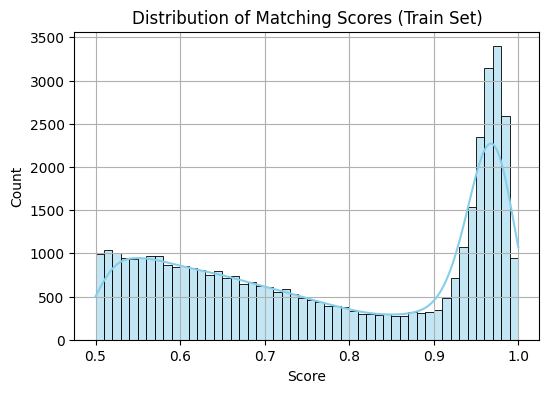

Score stats:
Min: 0.5000008980994213
Max: 0.9998107522735143
Mean: 0.7769


In [66]:
plt.figure(figsize=(6, 4))
sns.histplot(df_train['score'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Matching Scores (Train Set)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print("Score stats:")
print("Min:", df_train['score'].min())
print("Max:", df_train['score'].max())
print("Mean:", round(df_train['score'].mean(), 4))

In [67]:
for name, df in zip(['train', 'val', 'test'], [df_train, df_val, df_test]):
    missing = sum(not os.path.exists(os.path.join(img_dir, fname)) for fname in df["image_file"])
    print(f"Missing image files in {name} set: {missing} out of {len(df)}")

Missing image files in train set: 0 out of 41321
Missing image files in val set: 0 out of 3271
Missing image files in test set: 0 out of 10003


In [68]:
audio_ids = set(os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(".mp3"))

# Get numeric part of audio_id from matching files (e.g. "2009-114" → "2009")
def extract_numeric_audio_id(audio_id):
    return audio_id.split("-")[0]

matching_audio_ids = set(
    extract_numeric_audio_id(aid)
    for aid in pd.concat([df_train, df_val, df_test])["audio_id"]
)

# Compare actual vs expected
missing_mp3s = matching_audio_ids - audio_ids
extra_mp3s = audio_ids - matching_audio_ids

print("Total unique numeric audio_ids in matchings:", len(matching_audio_ids))
print("Total uploaded audio files:", len(audio_ids))
print("Missing audio files:", len(missing_mp3s))
print("Extra audio files (not used):", len(extra_mp3s))
if missing_mp3s:
    print("Example missing:", list(missing_mp3s)[:5])

Total unique numeric audio_ids in matchings: 1802
Total uploaded audio files: 1802
Missing audio files: 0
Extra audio files (not used): 0



Number of sampled audio files: 150

Sampled duration stats:
Avg: 51.39 s
Min: 44.94 s
Max: 401.03 s
Median: 45.0 s


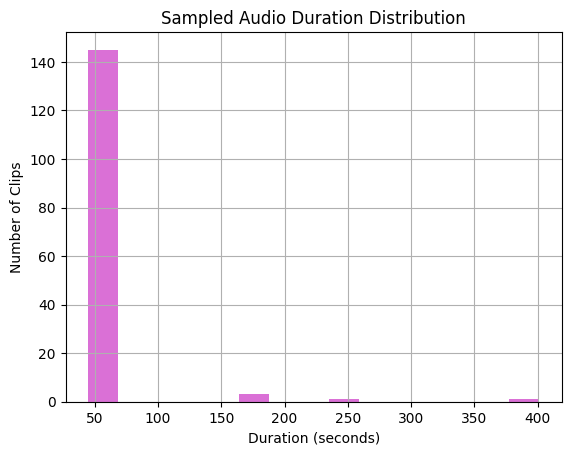

In [61]:
SAMPLE_FILES_LEN = min(150, len(audio_ids))
sampled_ids = sample(list(audio_ids), SAMPLE_FILES_LEN)

print(f"\nNumber of sampled audio files: {len(sampled_ids)}")

durations = []

for aid in sampled_ids:
    path = os.path.join(audio_dir, f"{aid}.mp3")
    try:
        y, sr = librosa.load(path, sr=None)
        durations.append(len(y) / sr)
    except Exception as e:
        print(f"Failed to load {aid}.mp3:", e)

print("\nSampled duration stats:")
print("Avg:", round(np.mean(durations), 2), "s")
print("Min:", round(np.min(durations), 2), "s")
print("Max:", round(np.max(durations), 2), "s")
print("Median:", round(np.median(durations), 2), "s")

plt.hist(durations, bins=15, color='orchid')
plt.title("Sampled Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Clips")
plt.grid(True)
plt.show()

In [69]:
sr_list = []
failures = []

for fname in os.listdir(audio_dir):
    if fname.endswith(".mp3"):
        path = os.path.join(audio_dir, fname)
        try:
            info = sf.SoundFile(path)
            sr_list.append(info.samplerate)
        except Exception as e:
            failures.append(fname)

# Count occurrences of each SR
sr_counter = Counter(sr_list)

# Print summary
print("🎚 Sampling Rate Distribution (All Files):")
for rate, count in sr_counter.items():
    print(f"{rate} Hz: {count} files")

print(f"\nTotal analyzed: {len(sr_list)}")
print(f"Failed to read: {len(failures)}")
if failures:
    print("Example failed files:", failures[:5])

🎚 Sampling Rate Distribution (All Files):
44100 Hz: 1778 files
48000 Hz: 20 files
16000 Hz: 1 files
22050 Hz: 3 files

Total analyzed: 1802
Failed to read: 0


In [71]:
# Use:
# batch = next(iter(train_loader))

# print("Image:", batch["image"].shape)        # [B, 3, 224, 224]
# print("Audio:", batch["audio_raw"].shape)    # [B, sr * max_sec]
# print("Score:", batch["score"].shape)        # [B]
# print("IDs:", batch["audio_id"])             # List of IDs

# train_loader
# test_loader
# val_loader

Image: torch.Size([32, 3, 224, 224])
Audio: torch.Size([32, 2205000])
Score: torch.Size([32])
IDs: ['1550-19', '1227-12', '2043-81', '653-10', '458-19', '1015-14', '1465-10', '1722-19', '1957-18', '1482-14', '1307-10', '2056-9', '7-13', '1705-17', '1886-9', '40-14', '1208-9', '1956-9', '2036-138', '250-20', '623-20', '1353-19', '1553-20', '1523-14', '194-13', '1001-9', '1621-19', '1152-11', '64-15', '1999-17', '2012-32', '2055-105']
